# US National Park Biodiversity

## I. Introduction

First, we need to import our essential libaries for analysis and display. We will also import our data into the corresponding variables.

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

parks = pd.read_csv('data/parks.csv')
species = pd.read_csv('data/species.csv', low_memory=False)

## II. Analysis

### A. Preprocessing

In [2]:
parks.head()

,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


In [3]:
species.head()

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,NaN
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,NaN
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,NaN
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,NaN
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,NaN


In [4]:
species.isna().sum()

Species ID                  0
Park Name                   0
Category                    0
Order                    1472
Family                   1512
Scientific Name             0
Common Names                0
Record Status               0
Occurrence              20142
Nativeness              25045
Abundance               42942
Seasonality             99091
Conservation Status    114530
Unnamed: 13            119243
dtype: int64

Cleaning data, decided to drop columns from each dataset.

From `parks.csv`: park code and acres
From `species.csv`: species ID, scientific name, record status, occurance, seasonality, and extra column

In [5]:
species['Conservation Status'] = species.apply(
    lambda row: row['Unnamed: 13'] 
    if row['Conservation Status'] == 'Resident' or 'Breeder' or 'Migratory'
    else row['Conservation Status'], axis=1
)

In [6]:
parks.drop(
    labels=['Park Code', 'Acres'],
    inplace=True, axis=1
)

species.drop(
    labels=['Species ID','Order','Family','Record Status','Occurrence','Seasonality','Unnamed: 13'],
    inplace=True, axis=1
)

In [7]:
parks.head()

,Park Name,State,Latitude,Longitude
0,Acadia National Park,ME,44.35,-68.21
1,Arches National Park,UT,38.68,-109.57
2,Badlands National Park,SD,43.75,-102.50
3,Big Bend National Park,TX,29.25,-103.25
4,Biscayne National Park,FL,25.65,-80.08


In [8]:
species.head()

,Park Name,Category,Scientific Name,Common Names,Nativeness,Abundance,Conservation Status
0,Acadia National Park,Mammal,Alces alces,Moose,Native,Rare,NaN
1,Acadia National Park,Mammal,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Native,Abundant,NaN
2,Acadia National Park,Mammal,Canis latrans,"Coyote, Eastern Coyote",Not Native,Common,NaN
3,Acadia National Park,Mammal,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Native,NaN,NaN
4,Acadia National Park,Mammal,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Unknown,Common,NaN


In [9]:
species.isna().sum()

Park Name                   0
Category                    0
Scientific Name             0
Common Names                0
Nativeness              25045
Abundance               42942
Conservation Status    119243
dtype: int64

In [10]:
print(parks.columns)
print(species.columns)

Index(['Park Name', 'State', 'Latitude', 'Longitude'], dtype='object')
Index(['Park Name', 'Category', 'Scientific Name', 'Common Names',
       'Nativeness', 'Abundance', 'Conservation Status'],
      dtype='object')


In [11]:
parks.columns=['park_name', 'state', 'latitude', 'longtitude']
species.columns=['park_name', 'category', 'scientific_name','common_names', 'nativeness', 'abundance', 'conservation_status']

In [12]:
parks.head()

,park_name,state,latitude,longtitude
0,Acadia National Park,ME,44.35,-68.21
1,Arches National Park,UT,38.68,-109.57
2,Badlands National Park,SD,43.75,-102.50
3,Big Bend National Park,TX,29.25,-103.25
4,Biscayne National Park,FL,25.65,-80.08


In [13]:
species.head()

,park_name,category,scientific_name,common_names,nativeness,abundance,conservation_status
0,Acadia National Park,Mammal,Alces alces,Moose,Native,Rare,NaN
1,Acadia National Park,Mammal,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Native,Abundant,NaN
2,Acadia National Park,Mammal,Canis latrans,"Coyote, Eastern Coyote",Not Native,Common,NaN
3,Acadia National Park,Mammal,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Native,NaN,NaN
4,Acadia National Park,Mammal,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Unknown,Common,NaN


Merging the two datasets for easier navigation for analysis

In [14]:
park_species = pd.merge(species, parks, on="park_name", how="outer")
park_species

,park_name,category,scientific_name,common_names,nativeness,abundance,conservation_status,state,latitude,longtitude
0,Acadia National Park,Mammal,Alces alces,Moose,Native,Rare,NaN,ME,44.35,-68.21
1,Acadia National Park,Mammal,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Native,Abundant,NaN,ME,44.35,-68.21
2,Acadia National Park,Mammal,Canis latrans,"Coyote, Eastern Coyote",Not Native,Common,NaN,ME,44.35,-68.21
3,Acadia National Park,Mammal,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Native,NaN,NaN,ME,44.35,-68.21
4,Acadia National Park,Mammal,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Unknown,Common,NaN,ME,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...
119243,Zion National Park,Vascular Plant,Solanum triflorum,Cut-Leaf Nightshade,Native,Uncommon,NaN,UT,37.30,-113.05
119244,Zion National Park,Vascular Plant,Vitis arizonica,Canyon Grape,Native,Uncommon,NaN,UT,37.30,-113.05
119245,Zion National Park,Vascular Plant,Vitis vinifera,Wine Grape,Not Native,Uncommon,NaN,UT,37.30,-113.05
119246,Zion National Park,Vascular Plant,Larrea tridentata,Creosote Bush,Native,Rare,NaN,UT,37.30,-113.05


### B. Data Exploration

Way more Vascular Plants, must keep in mind when identifying number of species that are identified as endangered

Text(0.5, 1.0, 'Total Species by Category')

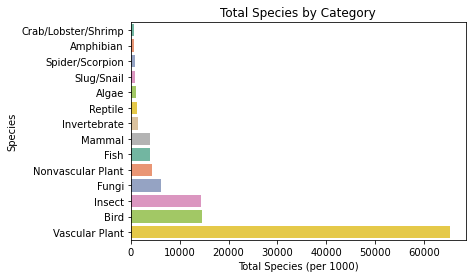

In [33]:
species_categories = park_species.groupby('category').scientific_name.count().reset_index()
species_categories.columns = ['category', 'species_count']
species_categories.sort_values(by='species_count', inplace=True)

sns.barplot(x='species_count', y='category', data=species_categories, palette='Set2')
plt.xlabel("Total Species (per 1000)")
plt.ylabel("Species")
plt.title("Total Species by Category")